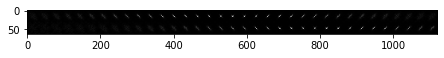

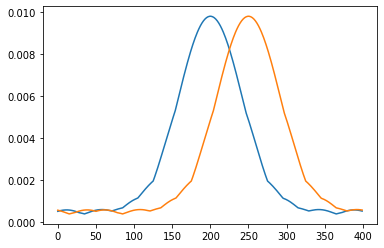

In [1]:
from tifffile import imwrite
from config.datasets import dataset_configs
from config.optics import bounds
from data.visualise import show_psf_axial, scatter_3d, scatter_yz
from debug_tools.dataset_simulator.sphere import sphere_center
from pyotf.otf import HanserPSF, apply_aberration, apply_named_aberration
from debug_tools.dataset_simulator.sphere import main as sphere_main, surface_density_nm2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
z_range = 1000


UPSCALE_RATIO = 5
ROLL = 50
EXPECTED_ROLL = UPSCALE_RATIO*ROLL

np.random.seed(42)

model_kwargs = dict(
    wl=647,
    na=1.3,
    ni=1.51,
    res=106,
    zres=10,
    size=32,
    zsize=400,
    vec_corr="none",
    condition="none",
)
    
def gen_fake_psf(model_kwargs):
    model = HanserPSF(**model_kwargs)
    # model = apply_named_aberration(model, 'oblique astigmatism', 2)
    model = apply_aberration(model, np.array([0, 0, 0, 0, 0]), np.array([0, 0, 0, 0, 2]))

    psf = model.PSFi
    psf = psf.astype(float)
    # psf = psf / psf.max()
    return psf

psf = gen_fake_psf(model_kwargs)

psf2 = np.roll(psf, ROLL, axis=0)
# pad_diff = abs(np.array(psf.shape) - np.array(psf2.shape))
# pad_diff = tuple((0, p) for p in pad_diff)

# if psf.shape[0] < psf2.shape[0]:
#     psf = np.pad(psf, pad_diff)
# else:
#     psf2 = np.pad(psf2, pad_diff)

# print(psf.shape, psf2.shape)
psfs = np.concatenate((psf, psf2), axis=2)
show_psf_axial(psfs)

for p in (psf, psf2):
    plt.plot(p.max(axis=(1,2)))
plt.show()

psf = psf / psf.max()
psf2 = psf2 / psf2.max()

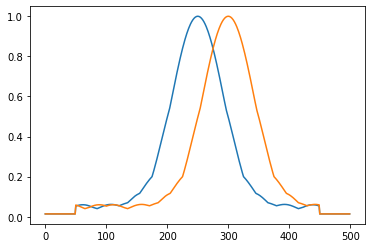

In [2]:
def pad_psf(psf):
    return np.pad(psf, ((50, 50), (0, 0), (0, 0)), mode='constant', constant_values=np.mean(psf))

psf = pad_psf(psf)
psf2 = pad_psf(psf2)                  
for p in (psf, psf2):
    plt.plot(p.max(axis=(1,2)))
plt.show()

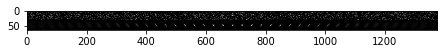

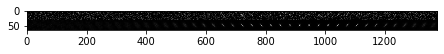

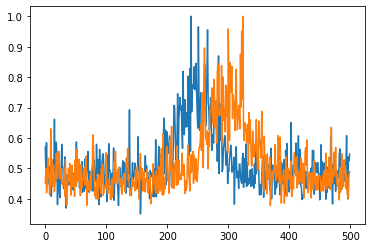

In [3]:
def noise_psf(_psf):
    _psf = _psf / _psf.max()
    psf = _psf.copy()
    # add bg
    psf += np.random.normal(loc=1e-2, scale=0.2, size=psf.shape)
    psf *= 1e3
    psf[psf<0] = 0
    psf = np.random.poisson(psf)
    psf = psf / psf.max()
    
    
    show_psf_axial(np.concatenate((psf, _psf), axis=2))
    
    return psf / psf.max()
    
psf = noise_psf(psf)
psf2 = noise_psf(psf2)

for p in (psf, psf2):
    plt.plot(p.max(axis=(1,2)))
plt.show()

100%|██████████| 1024/1024 [00:02<00:00, 409.42it/s]


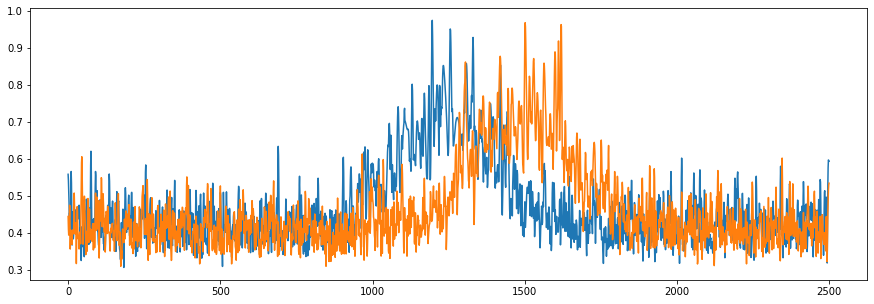

In [4]:
from scipy.interpolate import UnivariateSpline
from multiprocessing import Pool
from tqdm import trange
from itertools import product
from functools import partial
import tqdm

plt.rcParams['figure.figsize'] = [15, 5]


def pad_and_fit_spline(coords, pad_width, psf, z, z_ups):
    x, y = coords
    zs = psf[:, x, y]
    zs = np.pad(zs, (pad_width, pad_width), mode='edge')
    cs = UnivariateSpline(z, zs, k=3, s=0.5)
    if max(cs(z_ups)) > 2:
        plt.plot(z, zs, label='raw')
        plt.plot(z_ups, cs(z_ups), '.', label='smooth')
        plt.legend()
        plt.show()
    return x, y, cs(z_ups)
    
def upsample_psf(psf, ratio=UPSCALE_RATIO):
    pad_width = 5
    z = np.arange(-pad_width, psf.shape[0] + pad_width)
    z_ups = np.arange(0, psf.shape[0], 1/ratio)
    upsampled_psf = np.zeros((z_ups.shape[0], *psf.shape[1:]))
    
    xys = list(product(np.arange(psf.shape[1]), np.arange(psf.shape[2])))
    func = partial(pad_and_fit_spline, pad_width=pad_width, psf=psf, z=z, z_ups=z_ups)
    with Pool(8) as p:
        res = list(tqdm.tqdm(p.imap(func, xys), total=len(xys)))
    for x, y, z_col in res:
        upsampled_psf[:, x, y] = z_col
    return upsampled_psf

#     for x in trange(psf.shape[1]):
#         for y in range(psf.shape[2]):
#             zs = psf[:, x, y]
#             zs = np.pad(zs, (pad_width, pad_width), mode='edge')
#             cs = UnivariateSpline(z, zs, k=3, s=0.5)
#             if max(cs(z_ups)) > 2:
#                 plt.plot(z, zs, label='raw')
#                 plt.plot(z_ups, cs(z_ups), '.', label='smooth')
#                 plt.legend()
#                 plt.show()
            
#             upsampled_psf[:, x, y] = cs(z_ups)
#     return upsampled_psf
psf_up = upsample_psf(psf)
psf2_up = upsample_psf(psf2)
for p in (psf_up, psf2_up):
    plt.plot(p.max(axis=(1,2)))
plt.show()

In [36]:
%load_ext autoreload
%autoreload 2
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.set_soft_device_placement(True)
tf.debugging.set_log_device_placement(True)


def tf_mse(A, B):
    return tf.math.reduce_mean(tf.pow(A-B, 2))

def find_optimal_roll(ref, img):
    ref_tf = tf.convert_to_tensor(ref)
    img_tf = tf.convert_to_tensor(img)
    errors = []
    for i in range(img.shape[0]):
        error = tf_mse(ref_tf, img_tf)
        errors.append(error)
        img_tf = tf.roll(img_tf, 1, axis=0)
    return tf.argmin(tf.stack(errors)).numpy()

    
    
import time
t1 = time.time()
res = find_optimal_roll(psf2_up, psf_up)
t2 = time.time()

# Took: 14.69363021850586
print(f'Took: {t2-t1}')
print('Result', res)
print('Expected', EXPECTED_ROLL)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Num GPUs Available:  1
Took: 34.97896361351013
Result 248
Expected 250


100%|██████████| 2500/2500 [00:14<00:00, 171.07it/s]


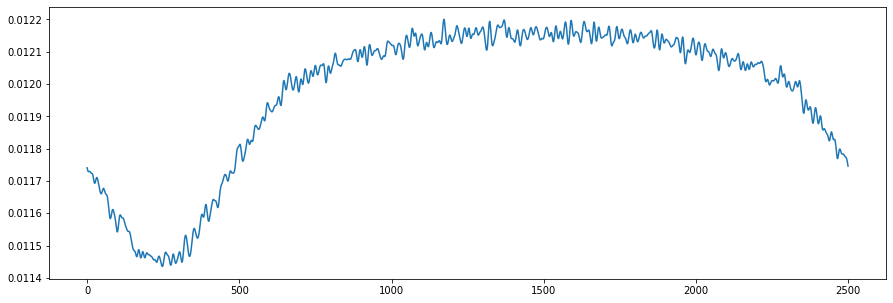

Took: 14.69363021850586
Result 247
Expected 250
0.01174601699192282
0.011436231429345058


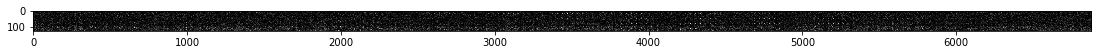

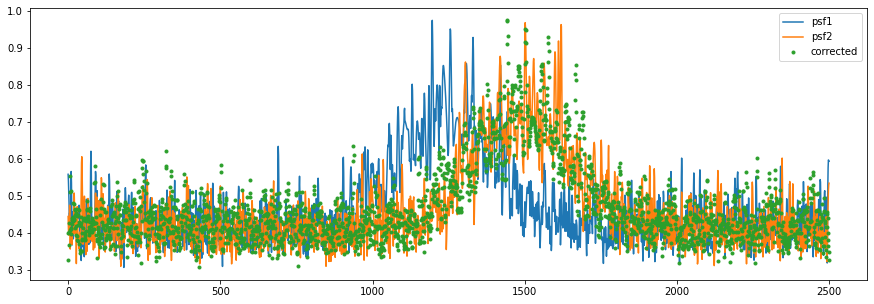

In [5]:
from scipy.signal import correlate
from functools import partial
from multiprocessing import Pool
from tqdm import trange

def mse(A,B):
    return np.mean((A-B)**2)

def roll_and_mse(roll_sets, target, img):
    i_s = []
    errors = []
    for i in roll_sets:
        img = np.roll(img, i, axis=0)
        i_s.append(i)
        error = mse(target, img)
        errors.append(error)

    return np.array(i_s), np.array(errors)

def find_optimal_roll(target, img):
#     pool_size = 16
    
#     possible_rolls = np.arange(0, img.shape[0])
#     roll_sets = np.array_split(possible_rolls, pool_size)
    
#     func = partial(roll_and_mse, target=target, img=img)
#     with Pool(pool_size) as p:
#         res = list(tqdm.tqdm(p.imap(func, roll_sets), total=len(roll_sets)))
    
#     i_s = np.array([np.array(r[0]) for r in res]).flatten()
#     errors = np.array([np.array(r[1]) for r in res]).flatten()
#     print(i_s.shape)
#     print(errors.shape)
#     for r in res:
#         plt.plot(r[0], r[1])
#         plt.show()
    i = 0
    min_error = mse(target, img)
    max_i = img.shape[0]
    best_i = 0
    i_s =[]
    errors = []
    for i in trange(i, max_i):
        img = np.roll(img, 1, axis=0)
        error = mse(target, img)
        if error < min_error:
            min_error = error
            best_i = i
        i_s.append(i)
        errors.append(error)

    plt.plot(i_s, errors)
    plt.show()
    return best_i
        
def argmax_coords(img):
    return np.unravel_index(img.argmlax(), img.shape)

import time
t1 = time.time()
res = find_optimal_roll(psf2_up, psf_up)
t2 = time.time()

# Took: 14.69363021850586
print(f'Took: {t2-t1}')
print('Result', res)
print('Expected', EXPECTED_ROLL)
psf_corrected = np.roll(psf_up, res, axis=0)

print(mse(psf_up, psf2_up))
print(mse(psf_corrected, psf2_up))

diff = abs(psf2_up - psf_corrected)
diff = diff / diff.max()
psfs = np.concatenate((psf_up, psf2_up, psf_corrected, diff), axis=2)

show_psf_axial(psfs)

plt.plot(psf_up.max(axis=(1,2)), label='psf1')
plt.plot(psf2_up.max(axis=(1,2)), label='psf2')
plt.plot(np.arange(0, psf_corrected.shape[0]), psf_corrected.max(axis=(1,2)), '.', label='corrected', )
plt.legend()
plt.show()
